In [21]:
# Import Libraries
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, datetime, tensorflow as tf, os, datetime
import tensorflow_probability as tfp

tfd = tfp.distributions

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint#, TensorBoard                                                                      
from keras import backend as K
from livelossplot import PlotLossesKeras
#from tensorboard.plugins.hparams import api as hp                                                                             
#from keras.utils.generic_utils import get_custom_objects                                                                      

import gc
gc.enable()

In [2]:
pwd

'/Users/tashaleebillings/Desktop/Tasha_Desktop/ThesisResearch/ML/notebooks'

In [22]:
toy_model = np.load('toy_models.npz')
nx, ny, ntrain = toy_model['training_data'].shape
training_data = toy_model['training_data'].T
labels = toy_model['labels']
outputdir = "./"

HP_EPOCH = 15
HP_BATCH_SIZE = 5
factor = 100

In [37]:
# Data Preprocessing                                                                                                                  
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 28, 28, 1) / 255.0
X_test = X_test.reshape(10000, 28, 28, 1) / 255.0
X_train = training_data[0:8000,:,:].reshape(8000,nx,ny,1)
y_train = labels[0:8000]*factor
X_test = training_data[8000:,:,:].reshape(2000,nx,ny,1)
y_test = labels[8000:]*factor

print("training", X_train.shape)
print("validation", X_test.shape)

NUM_TRAIN_EXAMPLES = len(training_data)
kl_divergence_function = (
lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(NUM_TRAIN_EXAMPLES,dtype=tf.float32)
)

training (8000, 32, 32, 1)
validation (2000, 32, 32, 1)


In [24]:
# Custom Loss Functions                                                                                                               
kl_divergence = tf.keras.losses.KLDivergence()

neg_log_likelihood = lambda y_true, y_pred: -tf.reduce_mean(input_tensor=y_pred.log_prob(y_true))

def Mean_Squared_over_true_Error(y_true, y_pred):
    # Create a custom loss function that divides the difference by the true                                                           

    y_true = K.cast(y_true, y_pred.dtype) #Casts a tensor to a different dtype and returns it.                                        
    diff_ratio = K.square((y_pred - y_true)/K.clip(K.abs(y_true),K.epsilon(),None))

    loss = K.mean(diff_ratio, axis=-1)

    # Return a tensor                                                                                                                 
    return loss

def elbo(y_true, y_pred):
    kl_weight = 1
    neg_log_likelihood = -tf.reduce_mean(input_tensor=y_pred.log_prob(y_true))
    kl_divergence = tf.keras.losses.KLDivergence()

    elbo_loss = -tf.math.reduce_mean(-kl_weight * kl_divergence(y_true, y_pred.mean()) - neg_log_likelihood)
    # Return a tensor                                                                                                                 
    return elbo_loss

def mean_fractional_error(y_true, y_pred):
    y_true = K.cast(y_true, y_pred.dtype) #Casts a tensor to a different dtype and returns it.
    diff_ratio = (y_pred - y_true)/K.clip(K.abs(y_true),K.epsilon(),None)
    loss = K.mean(diff_ratio, axis=-1)
    
    return loss
    

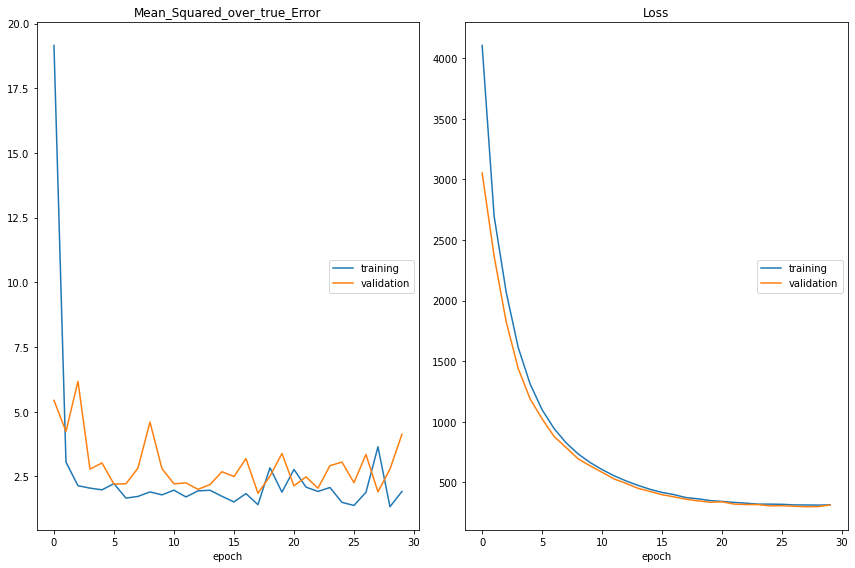

Mean_Squared_over_true_Error
	training         	 (min:    1.327, max:   19.156, cur:    1.919)
	validation       	 (min:    1.851, max:    6.171, cur:    4.129)
Loss
	training         	 (min:  311.879, max: 4106.214, cur:  313.957)
	validation       	 (min:  298.441, max: 3053.710, cur:  313.309)
(2000, 32, 32, 1)
(2000,)
(2000,)


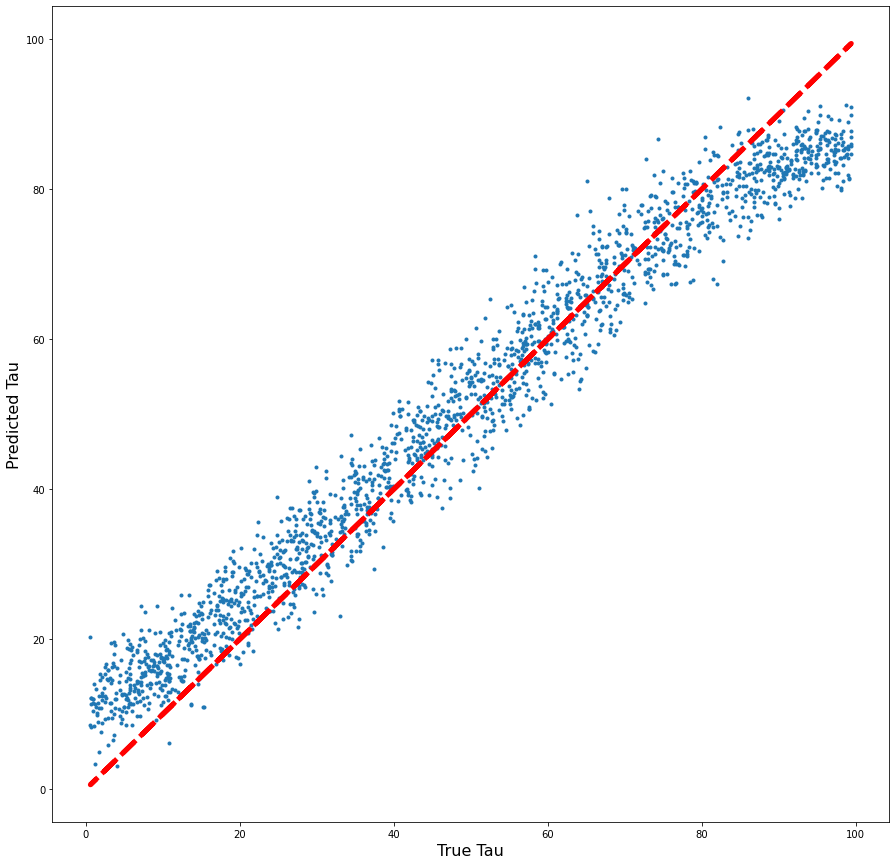

In [32]:

# Making a model.                                                                                                                                                                   
model = Sequential()

# Added Layers.                                                                                                                                                                     
#model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), kernel_size=3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Dense(8, activation = 'relu'))
model.add(tfp.layers.DenseFlipout(8, activation="relu"))
#model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())

#model.add(Dense(4, activation = 'relu'))
model.add(tfp.layers.DenseFlipout(4, activation="relu"))
#model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())

#model.add(Dense(2, activation = 'relu'))
model.add(tfp.layers.DenseFlipout(2, activation="relu"))
#model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())

#model.add(Dense(4, activation = 'relu'))
model.add(tfp.layers.DenseFlipout(4, activation="relu"))
#model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())

#model.add(Dense(2, activation = 'relu'))
model.add(tfp.layers.DenseFlipout(2, activation="relu"))
#model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())

#model.add(Dense(1, activation = 'relu'))
model.add(tfp.layers.DenseFlipout(1, activation="linear"))
#model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())

model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
#model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
model.add(BatchNormalization())
model.add(Flatten())

#model.add(Dense(1,activation="linear"))                                                                                                                                            
model.add(tfp.layers.DenseFlipout(1, activation="linear"))
#model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

model.compile(optimizer= "adam", loss = "mse", metrics=[Mean_Squared_over_true_Error])#, mean_fractional_error])#neg_log_likelihood)#"mse")#"mape")                                                                                                  

# Visualize Model                                                                                                                                                                                                           
print(model.summary())
plotlosses = PlotLossesKeras()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
      epochs=30, batch_size=HP_BATCH_SIZE,
      callbacks=[plotlosses],
      verbose=1)


# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

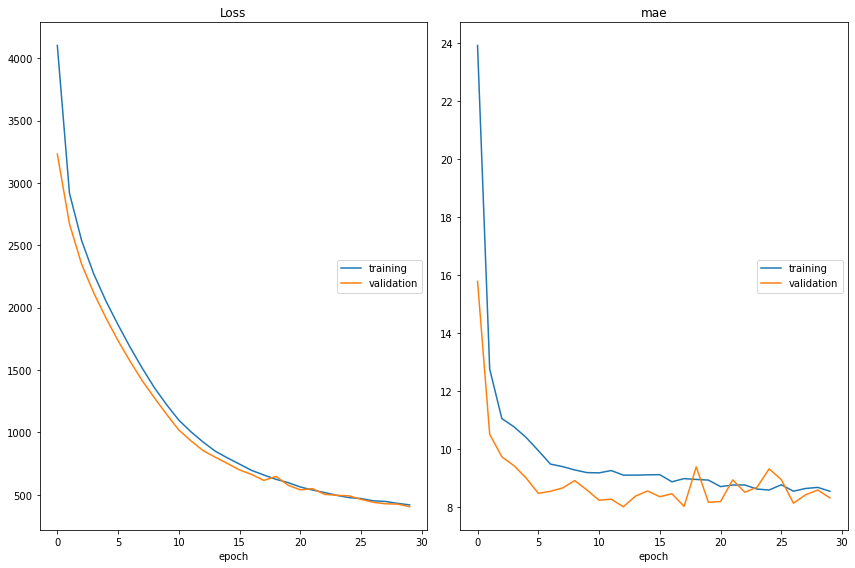

Loss
	training         	 (min:  418.354, max: 4102.895, cur:  418.354)
	validation       	 (min:  403.526, max: 3231.796, cur:  403.526)
mae
	training         	 (min:    8.552, max:   23.925, cur:    8.552)
	validation       	 (min:    8.018, max:   15.791, cur:    8.323)
(2000, 32, 32, 1)
(2000,)
(2000,)


'\nfig, axes = plt.subplots(3, 2, figsize=(15,15)) #,sharex=True,)\nfig.suptitle(\'Mean Square Error LossFunction\', size = 30)\nfig.subplots_adjust(top=20)\n\naxes[0, 0].set_title(\'One-to-One\', size = 16)\naxes[0, 0].plot(y_test/factor, predictions/factor, \'.\')\naxes[0, 0].plot(y_test/factor,y_test/factor, "r--", linewidth=5)\n\n# Mean Absolute Error\naxes[0, 1].set_title(\'Mean Absolute Error\', size = 16)\naxes[0, 1].plot(np.arange(len(history.history["mae"])), np.array(history.history["mae"]), \'--\', linewidth=5, label = "MAE")\naxes[0, 1].plot(np.arange(len(history.history["mae"])), np.array(history.history["val_mae"]), \'--\', linewidth=5, label = "Validation MAE")\n\n# Mean Fractional Error\naxes[1, 0].set_title(\'Mean Fractional Error\', size = 16)\naxes[1, 0].plot(np.arange(len(history.history["neg_log_likelihood"])), np.array(history.history["neg_log_likelihood"]), \'--\', linewidth=5, label = "Fractional Error")\naxes[1, 0].plot(np.arange(len(history.history["val_neg_lo

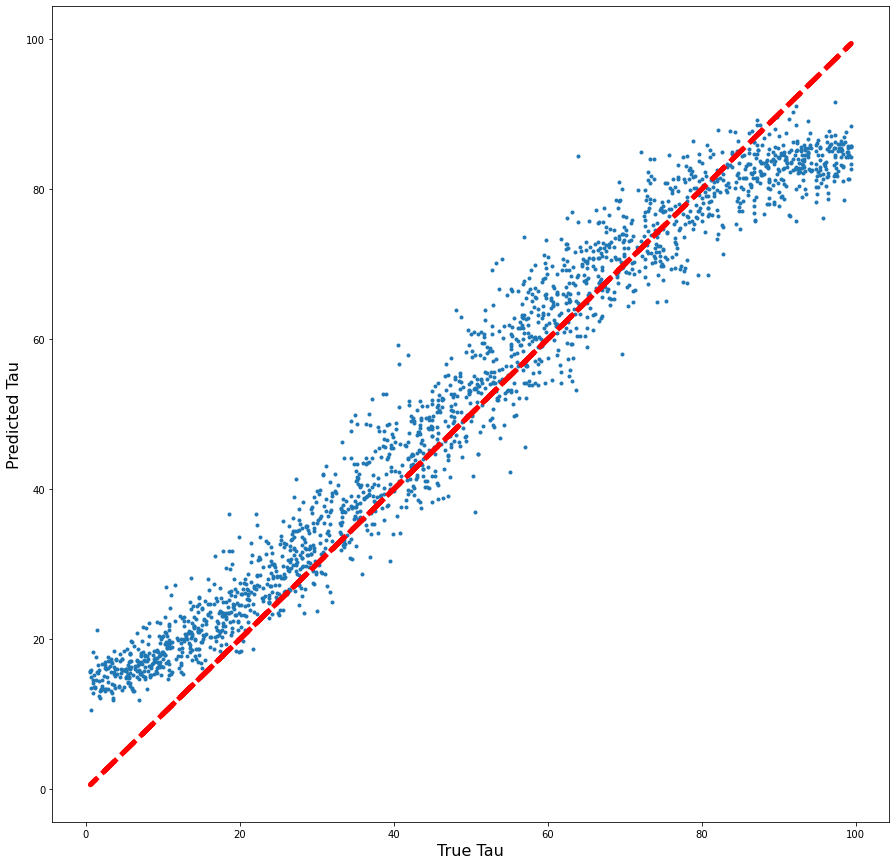

In [6]:

# Making a model.                                                                                                                                                                   
model = Sequential()

# Added Layers.                                                                                                                                                                     
#model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), kernel_size=3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Dense(8, activation = 'relu'))
model.add(tfp.layers.DenseFlipout(8, activation="relu"))
#model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())

#model.add(Dense(4, activation = 'relu'))
model.add(tfp.layers.DenseFlipout(4, activation="relu"))
#model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())

#model.add(Dense(2, activation = 'relu'))
model.add(tfp.layers.DenseFlipout(2, activation="relu"))
#model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())

#model.add(Dense(4, activation = 'relu'))
model.add(tfp.layers.DenseFlipout(4, activation="relu"))
#model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())

#model.add(Dense(2, activation = 'relu'))
model.add(tfp.layers.DenseFlipout(2, activation="relu"))
#model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())

#model.add(Dense(1, activation = 'relu'))
model.add(tfp.layers.DenseFlipout(1, activation="linear"))
#model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())

model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
#model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
model.add(BatchNormalization())
model.add(Flatten())

#model.add(Dense(1,activation="linear"))                                                                                                                                            
model.add(tfp.layers.DenseFlipout(1, activation="linear"))
#model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

model.compile(optimizer= "adam", loss = "mse", metrics=["mae"])#, mean_fractional_error])#neg_log_likelihood)#"mse")#"mape")                                                                                                  

# Visualize Model                                                                                                                                                                                                           
print(model.summary())
plotlosses = PlotLossesKeras()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
      epochs=30, batch_size=HP_BATCH_SIZE,
      callbacks=[plotlosses],
      verbose=1)


# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)
"""
fig, axes = plt.subplots(3, 2, figsize=(15,15)) #,sharex=True,)
fig.suptitle('Mean Square Error LossFunction', size = 30)
fig.subplots_adjust(top=20)

axes[0, 0].set_title('One-to-One', size = 16)
axes[0, 0].plot(y_test/factor, predictions/factor, '.')
axes[0, 0].plot(y_test/factor,y_test/factor, "r--", linewidth=5)

# Mean Absolute Error
axes[0, 1].set_title('Mean Absolute Error', size = 16)
axes[0, 1].plot(np.arange(len(history.history["mae"])), np.array(history.history["mae"]), '--', linewidth=5, label = "MAE")
axes[0, 1].plot(np.arange(len(history.history["mae"])), np.array(history.history["val_mae"]), '--', linewidth=5, label = "Validation MAE")

# Mean Fractional Error
axes[1, 0].set_title('Mean Fractional Error', size = 16)
axes[1, 0].plot(np.arange(len(history.history["neg_log_likelihood"])), np.array(history.history["neg_log_likelihood"]), '--', linewidth=5, label = "Fractional Error")
axes[1, 0].plot(np.arange(len(history.history["val_neg_log_likelihood"])), np.array(history.history["val_neg_log_likelihood"]), '--', linewidth=5, label = "Validation Fractional Error")

#axs[1, 1].plot(x, -y, 'tab:red')
axes[1, 1].set_title('Loss', size = 16)
axes[1, 1].plot(np.arange(len(history.history["loss"])), np.array(history.history["loss"]), '--', linewidth=5, label = "Loss")
axes[1, 1].plot(np.arange(len(history.history["val_loss"])), np.array(history.history["val_loss"]), '--', linewidth=5, label = "Validation Loss")

# Coefficient of Determination
axes[2,0].set_title('Coefficient of Determination', size = 16)

# Explained Variation
axes[2,1].set_title('Explained Variation', size = 16)

axes[0,0].set_yscale('linear')
axes[0,1].set_yscale('log')
axes[1,0].set_yscale('log')
axes[1,1].set_yscale('log')

axes[0,0].tick_params(labelcolor='k', labelsize=16, width=3)
axes[0,1].tick_params(labelcolor='k', labelsize=16, width=3)
axes[1,0].tick_params(labelcolor='k', labelsize=16, width=3)
axes[1,1].tick_params(labelcolor='k', labelsize=16, width=3)

axes[0,0].legend(markerscale=2.5)
plt.tight_layout()

"""
#for ax in fig.get_axes():
#    ax.label_outer()

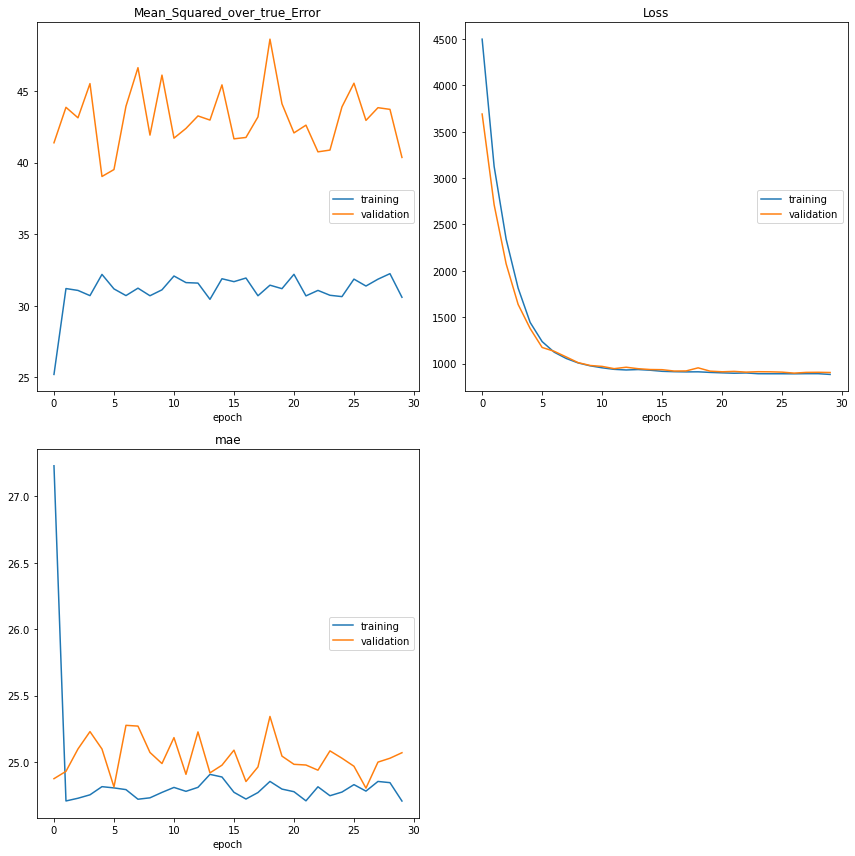

Mean_Squared_over_true_Error
	training         	 (min:   25.203, max:   32.241, cur:   30.592)
	validation       	 (min:   39.029, max:   48.619, cur:   40.359)
Loss
	training         	 (min:  883.576, max: 4497.895, cur:  883.576)
	validation       	 (min:  897.841, max: 3691.040, cur:  904.438)
mae
	training         	 (min:   24.706, max:   27.231, cur:   24.706)
	validation       	 (min:   24.803, max:   25.343, cur:   25.070)
(2000, 32, 32, 1)
(2000,)
(2000,)


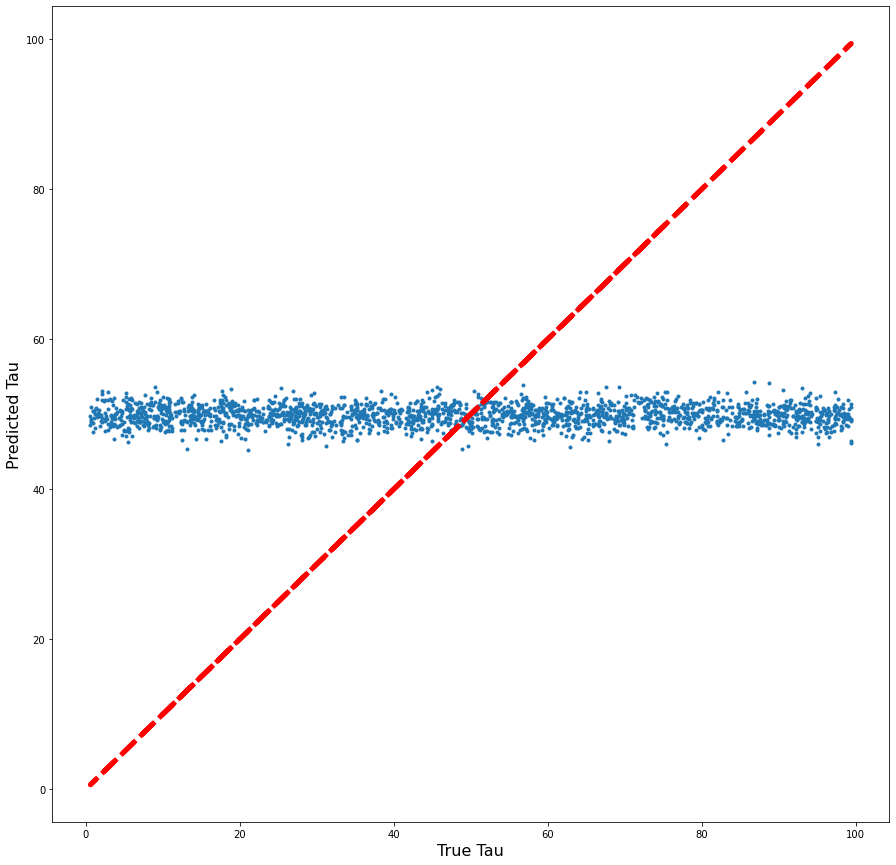

In [34]:
def train_test_model():
    # Making a model.                                                                                                                                                                   
    model = Sequential()

    # Added Layers.                                                                                                                                                                     
    #model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Dense(8, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(8, activation="relu"))
    #model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(1, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
    model.add(BatchNormalization())
    model.add(Flatten())

    #model.add(Dense(1,activation="linear"))                                                                                                                                            
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    #model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

    model.compile(optimizer= "adam", loss = "mse", metrics=["mae",Mean_Squared_over_true_Error])#neg_log_likelihood)#"mse")#"mape")                                                                                                  

    # Visualize Model                                                                                                                                                                                                           
    print(model.summary())
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=30, batch_size=HP_BATCH_SIZE,
          callbacks=[plotlosses],
          verbose=1)
    
    return model

model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

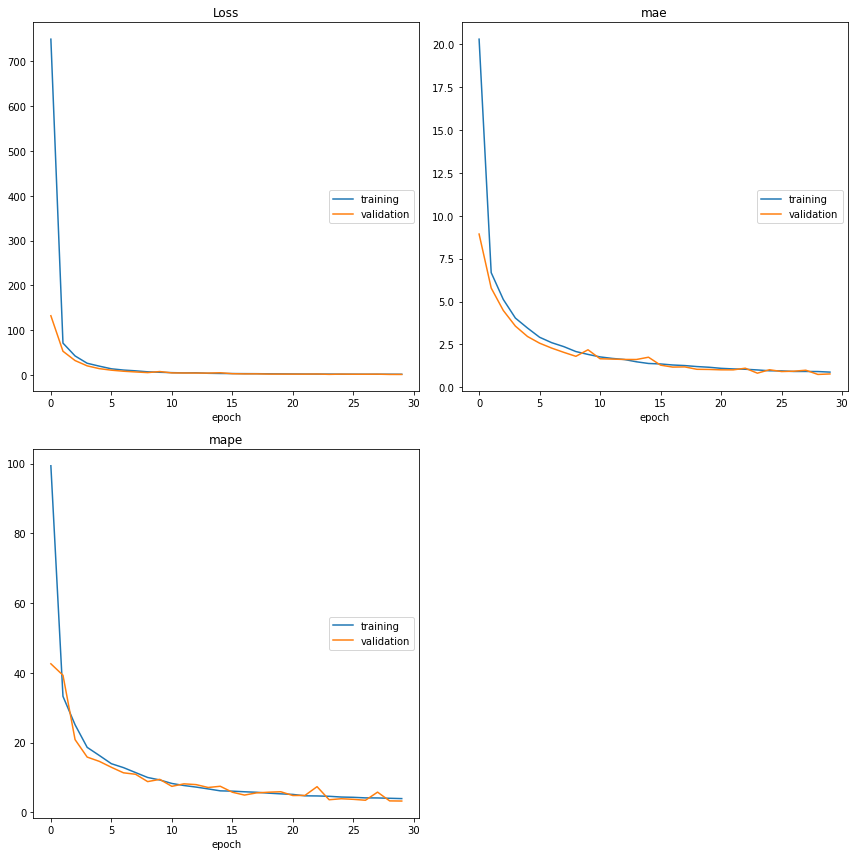

Loss
	training         	 (min:    1.738, max:  749.607, cur:    1.738)
	validation       	 (min:    1.404, max:  132.369, cur:    1.450)
mae
	training         	 (min:    0.883, max:   20.295, cur:    0.883)
	validation       	 (min:    0.748, max:    8.933, cur:    0.776)
mape
	training         	 (min:    3.971, max:   99.367, cur:    3.971)
	validation       	 (min:    3.274, max:   42.611, cur:    3.274)
(2000, 32, 32, 1)
(2000,)
(2000,)


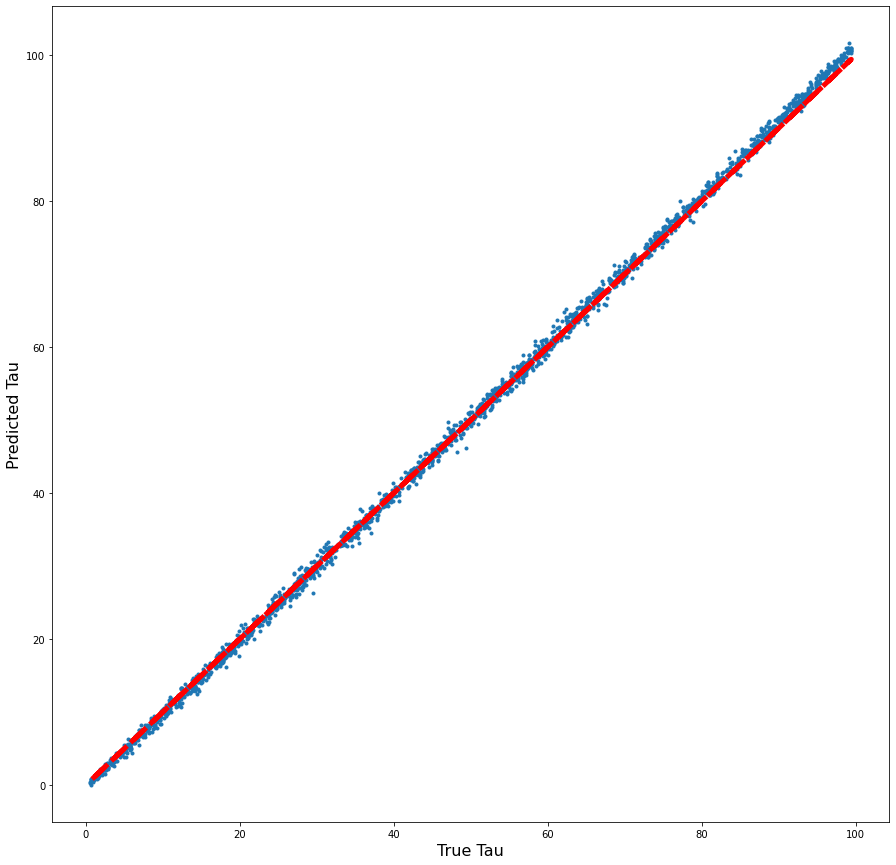

In [39]:
def train_test_model():
    # Making a model.                                                                                                                                                                   
    model = Sequential()

    # Added Layers.                                                                                                                                                                     
    #model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Dense(8, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(8, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(1, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
    model.add(BatchNormalization())
    model.add(Flatten())

    #model.add(Dense(1,activation="linear"))                                                                                                                                            
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    #model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

    model.compile(optimizer= "adam", loss = "mse", metrics=["mae", "mape"])#)#"mse")#"mape")                                                                                                  

    # Visualize Model                                                                                                                                                                                                           
    print(model.summary())
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=30, batch_size=HP_BATCH_SIZE,
          callbacks=[plotlosses],
          verbose=1)
    return model

model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

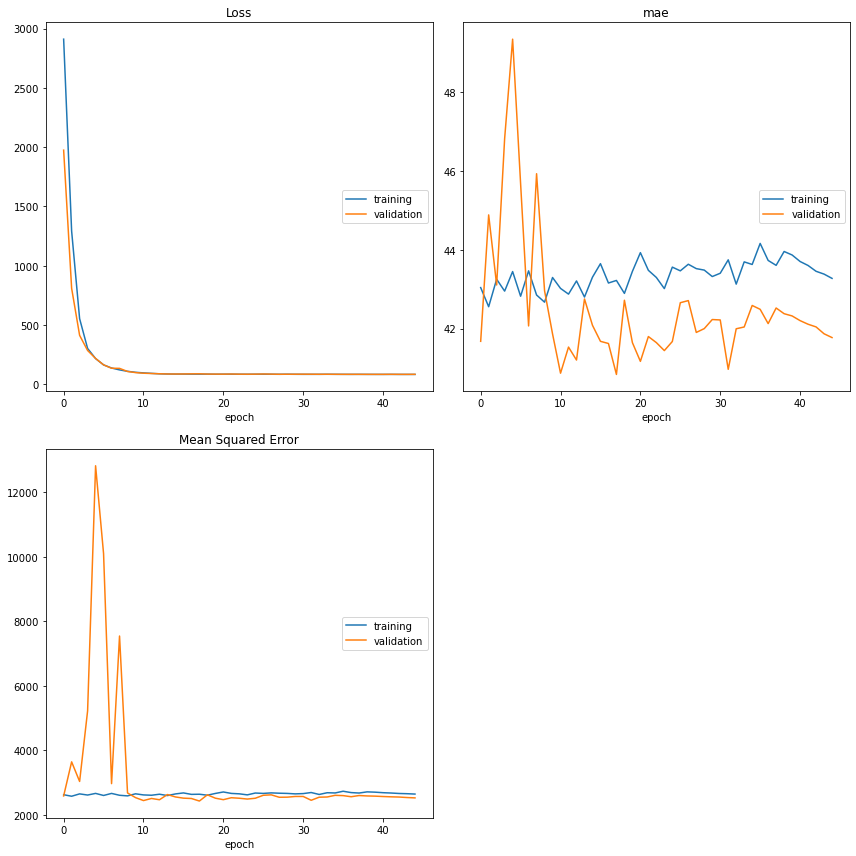

Loss
	training         	 (min:   84.183, max: 2910.146, cur:   84.183)
	validation       	 (min:   84.761, max: 1974.600, cur:   85.298)
mae
	training         	 (min:   42.556, max:   44.163, cur:   43.275)
	validation       	 (min:   40.836, max:   49.350, cur:   41.772)
Mean Squared Error
	training         	 (min: 2575.461, max: 2730.407, cur: 2642.933)
	validation       	 (min: 2426.599, max: 12826.885, cur: 2524.240)
(2000, 32, 32, 1)
(2000,)
(2000,)


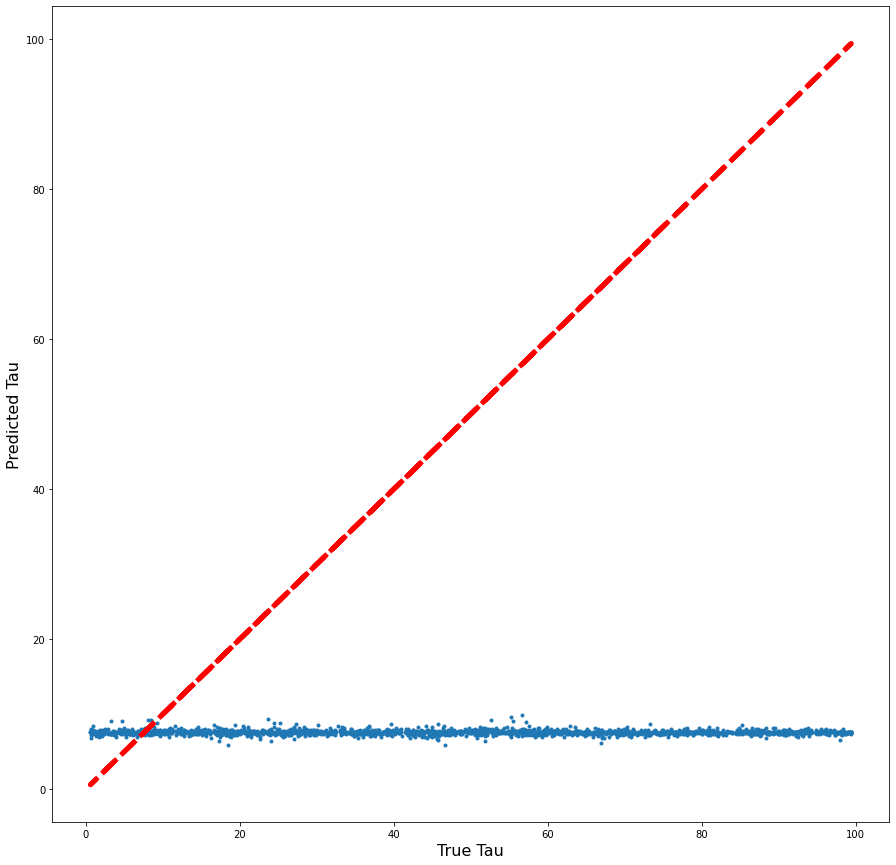

In [35]:
def train_test_model():
    # Making a model.                                                                                                                                                                   
    model = Sequential()

    # Added Layers.                                                                                                                                                                     
    #model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Dense(8, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(8, activation="relu"))
    #model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(1, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
    model.add(BatchNormalization())
    model.add(Flatten())

    #model.add(Dense(1,activation="linear"))                                                                                                                                            
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    #model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

    model.compile(optimizer= "adam", loss = "mape", metrics=["mae","mse"])#neg_log_likelihood)#"mse")#"mape")                                                                                                  

    # Visualize Model                                                                                                                                                                                                           
    print(model.summary())
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=45, batch_size=HP_BATCH_SIZE,
          callbacks=[plotlosses],
          verbose=1)
    
    return model

model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

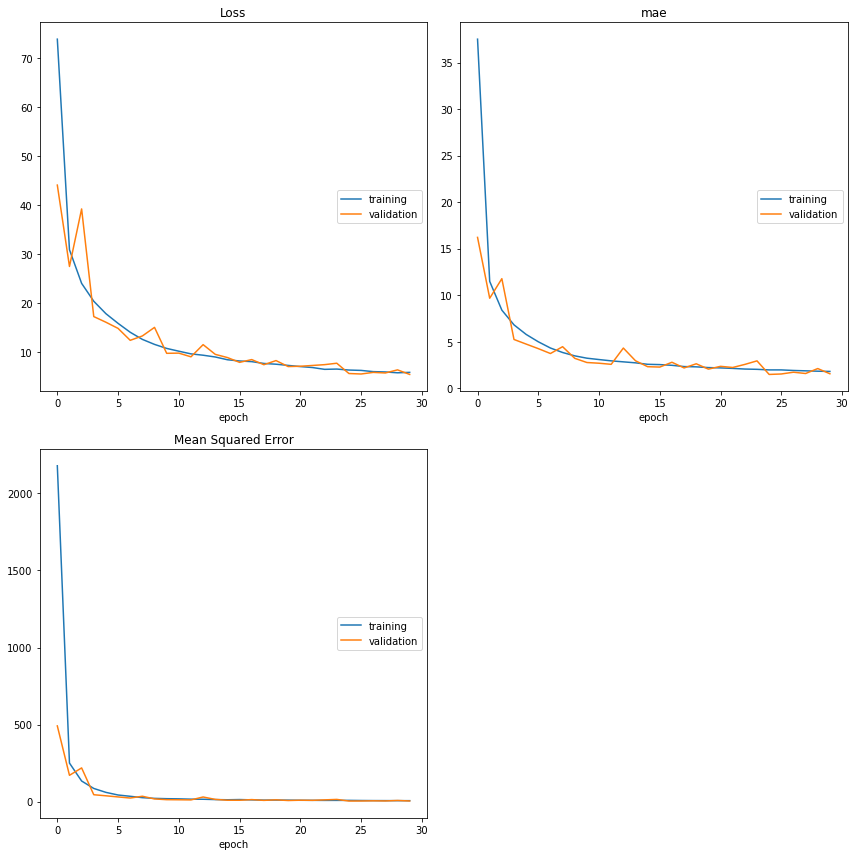

Loss
	training         	 (min:    5.829, max:   73.928, cur:    5.919)
	validation       	 (min:    5.494, max:   44.141, cur:    5.494)
mae
	training         	 (min:    1.807, max:   37.514, cur:    1.807)
	validation       	 (min:    1.483, max:   16.211, cur:    1.556)
Mean Squared Error
	training         	 (min:    5.992, max: 2179.699, cur:    5.992)
	validation       	 (min:    3.611, max:  491.260, cur:    4.016)
(2000, 32, 32, 1)
(2000,)
(2000,)


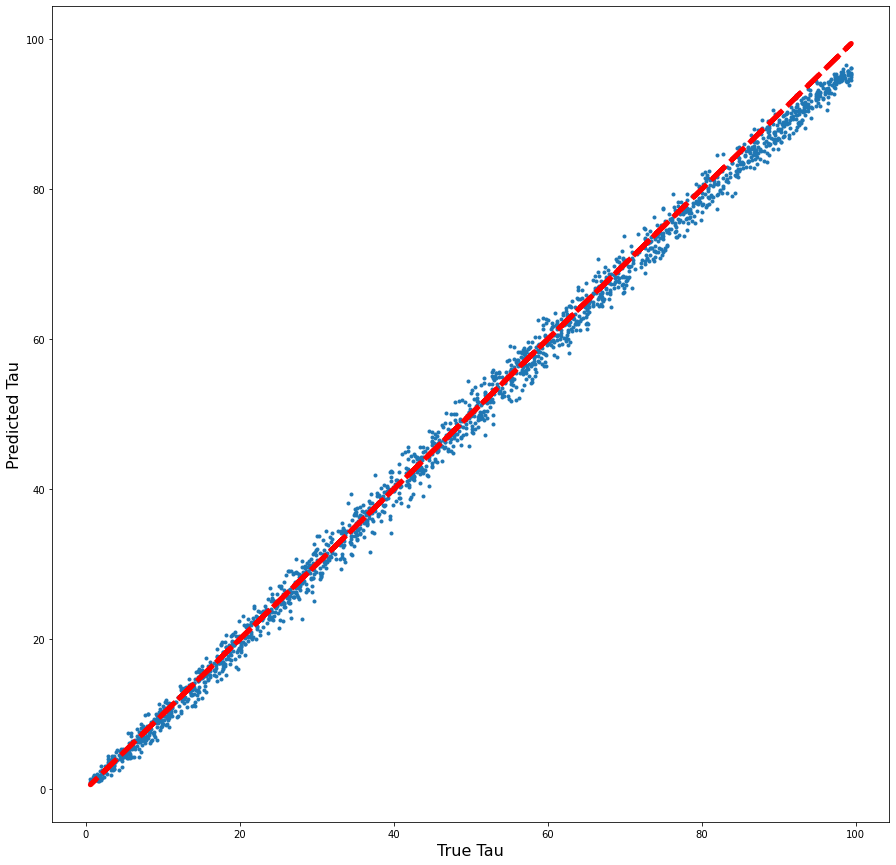

In [40]:
def train_test_model():
    # Making a model.                                                                                                                                                                   
    model = Sequential()

    # Added Layers.                                                                                                                                                                     
    #model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Dense(8, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(8, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(1, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
    model.add(BatchNormalization())
    model.add(Flatten())

    #model.add(Dense(1,activation="linear"))                                                                                                                                            
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    #model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

    model.compile(optimizer= "adam", loss = "mape", metrics=["mse", "mae"])#)#"mse")#"mape")                                                                                                  

    # Visualize Model                                                                                                                                                                                                           
    print(model.summary())
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=30, batch_size=HP_BATCH_SIZE,
          callbacks=[plotlosses],
          verbose=1)
    return model

model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

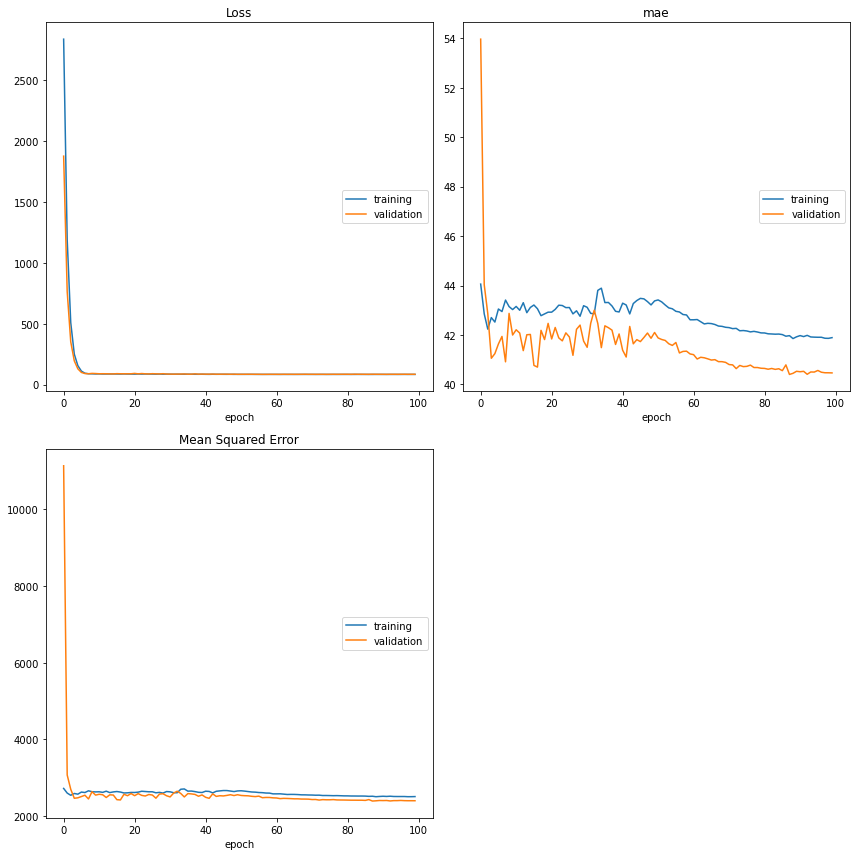

Loss
	training         	 (min:   83.754, max: 2837.619, cur:   83.857)
	validation       	 (min:   84.559, max: 1876.757, cur:   85.101)
mae
	training         	 (min:   41.855, max:   44.058, cur:   41.892)
	validation       	 (min:   40.404, max:   53.969, cur:   40.465)
Mean Squared Error
	training         	 (min: 2503.513, max: 2719.644, cur: 2506.831)
	validation       	 (min: 2390.542, max: 11140.631, cur: 2398.134)
(2000, 32, 32, 1)
(2000,)
(2000,)


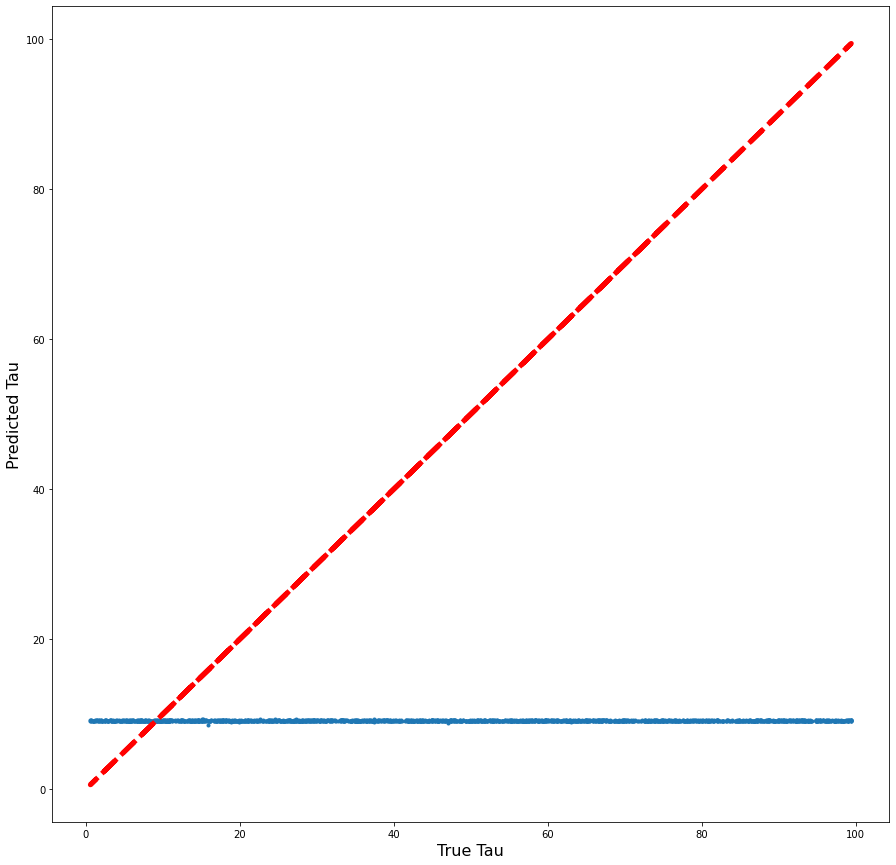

In [30]:
def train_test_model():
    # Making a model.                                                                                                                                                                   
    model = Sequential()

    # Added Layers.                                                                                                                                                                     
    #model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Dense(8, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(8, activation="relu"))
    #model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(1, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
    model.add(BatchNormalization())
    model.add(Flatten())

    #model.add(Dense(1,activation="linear"))                                                                                                                                            
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    #model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

    model.compile(optimizer= "adam", loss = "mape", metrics=["mae","mse"])#neg_log_likelihood)#"mse")#"mape")                                                                                                  

    # Visualize Model                                                                                                                                                                                                           
    print(model.summary())
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=100, batch_size=HP_BATCH_SIZE,
          callbacks=[plotlosses],
          verbose=1)
    
    return model

model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

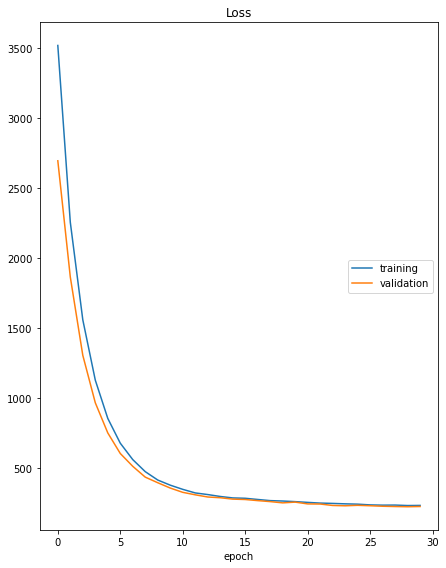

Loss
	training         	 (min:  232.080, max: 3520.851, cur:  232.926)
	validation       	 (min:  223.519, max: 2696.480, cur:  225.200)
(2000, 32, 32, 1)
(2000,)
(2000,)


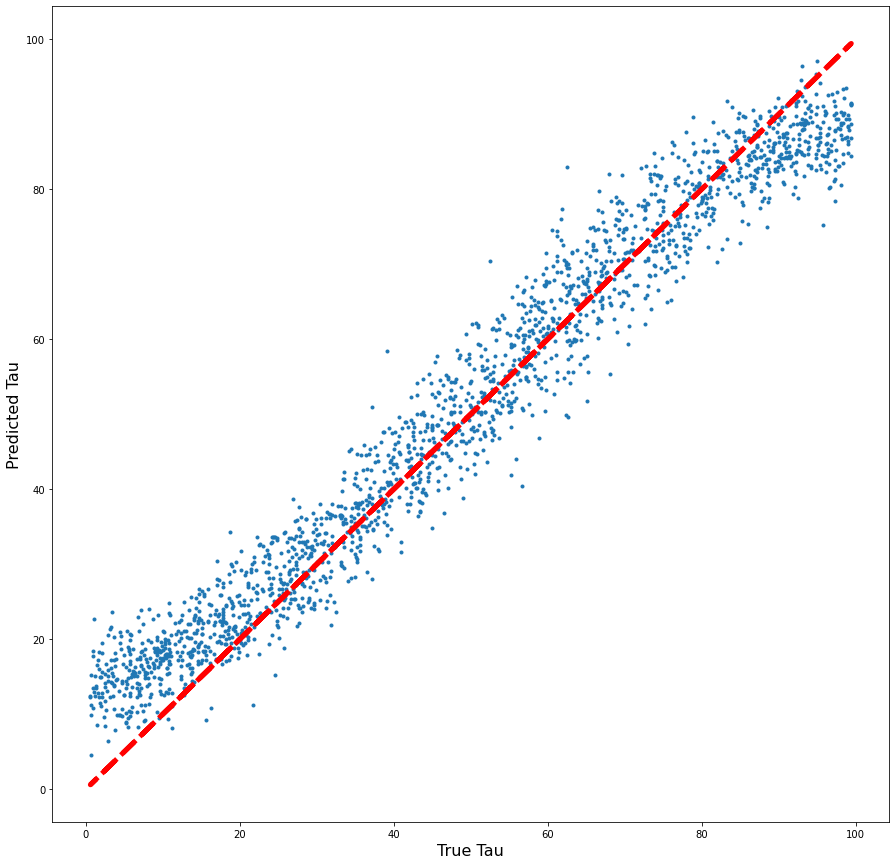

In [16]:
def train_test_model():
    # Making a model.                                                                                                                                                                   
    model = Sequential()

    # Added Layers.                                                                                                                                                                     
    #model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Dense(8, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(8, activation="relu"))
    #model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(1, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    #model.add(Conv2Db(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
    model.add(BatchNormalization())
    model.add(Flatten())

    #model.add(Dense(1,activation="linear"))                                                                                                                                            
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

    model.compile(optimizer= "adam", loss = neg_log_likelihood, metrics=[])#"mae","mse"])#)#"mse")#"mape")                                                                                                  

    # Visualize Model                                                                                                                                                                                                           
    print(model.summary())
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=30, batch_size=HP_BATCH_SIZE,
          callbacks=[plotlosses],
          verbose=1)
    return model

model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

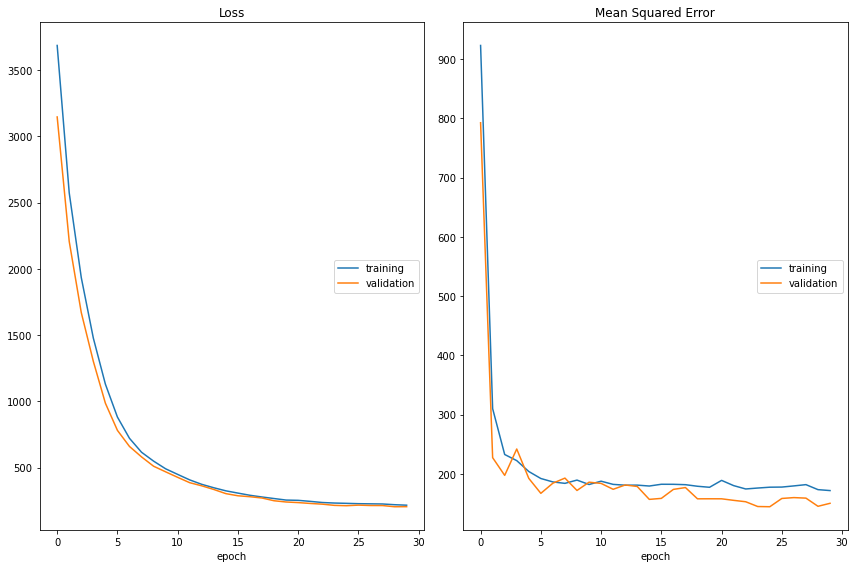

Loss
	training         	 (min:  216.558, max: 3685.001, cur:  216.558)
	validation       	 (min:  204.914, max: 3145.819, cur:  205.391)
Mean Squared Error
	training         	 (min:  171.948, max:  922.779, cur:  171.948)
	validation       	 (min:  144.682, max:  792.442, cur:  150.473)
(2000, 32, 32, 1)
(2000,)
(2000,)


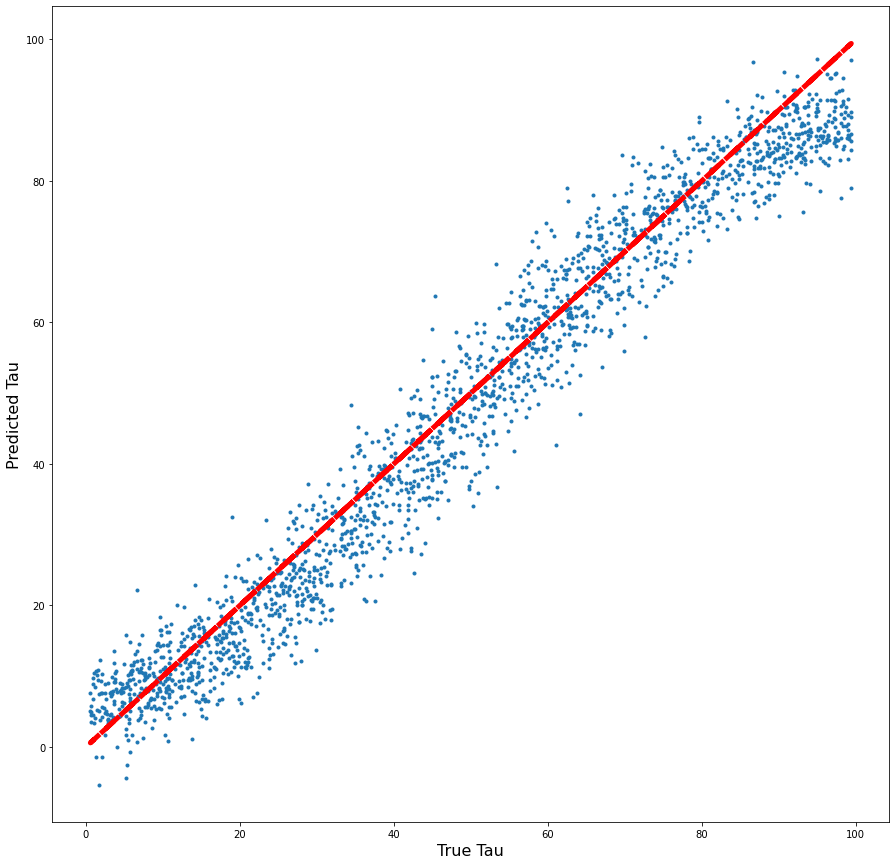

In [17]:
def train_test_model():
    # Making a model.                                                                                                                                                                   
    model = Sequential()

    # Added Layers.                                                                                                                                                                     
    #model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Dense(8, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(8, activation="relu"))
    #model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(1, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
    model.add(BatchNormalization())
    model.add(Flatten())

    #model.add(Dense(1,activation="linear"))                                                                                                                                            
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

    model.compile(optimizer= "adam", loss = neg_log_likelihood, metrics=["mse"])#"mae","mse"])#)#"mse")#"mape")                                                                                                  

    # Visualize Model                                                                                                                                                                                                           
    print(model.summary())
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=30, batch_size=HP_BATCH_SIZE,
          callbacks=[plotlosses],
          verbose=1)
    return model

model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

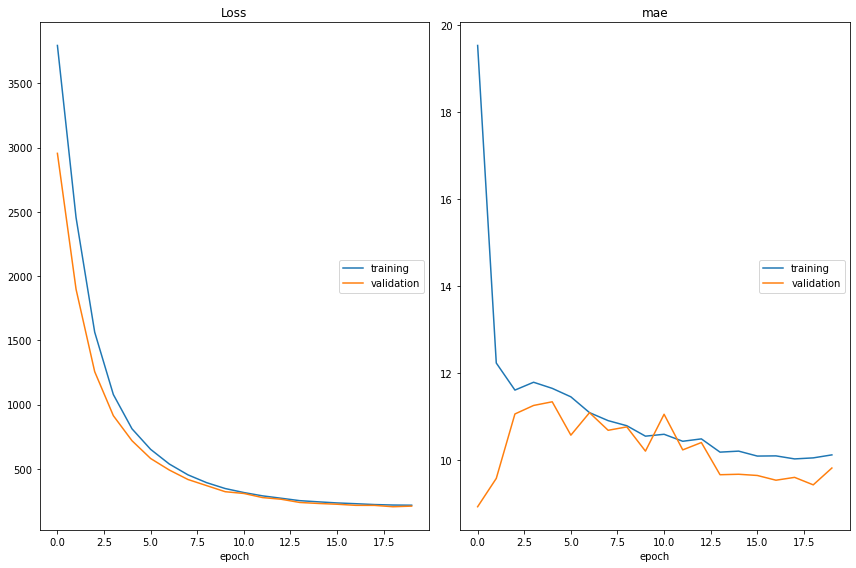

Loss
	training         	 (min:  216.799, max: 3795.164, cur:  216.799)
	validation       	 (min:  204.880, max: 2955.468, cur:  209.657)
mae
	training         	 (min:   10.026, max:   19.537, cur:   10.118)
	validation       	 (min:    8.925, max:   11.340, cur:    9.816)
(2000, 32, 32, 1)
(2000,)
(2000,)


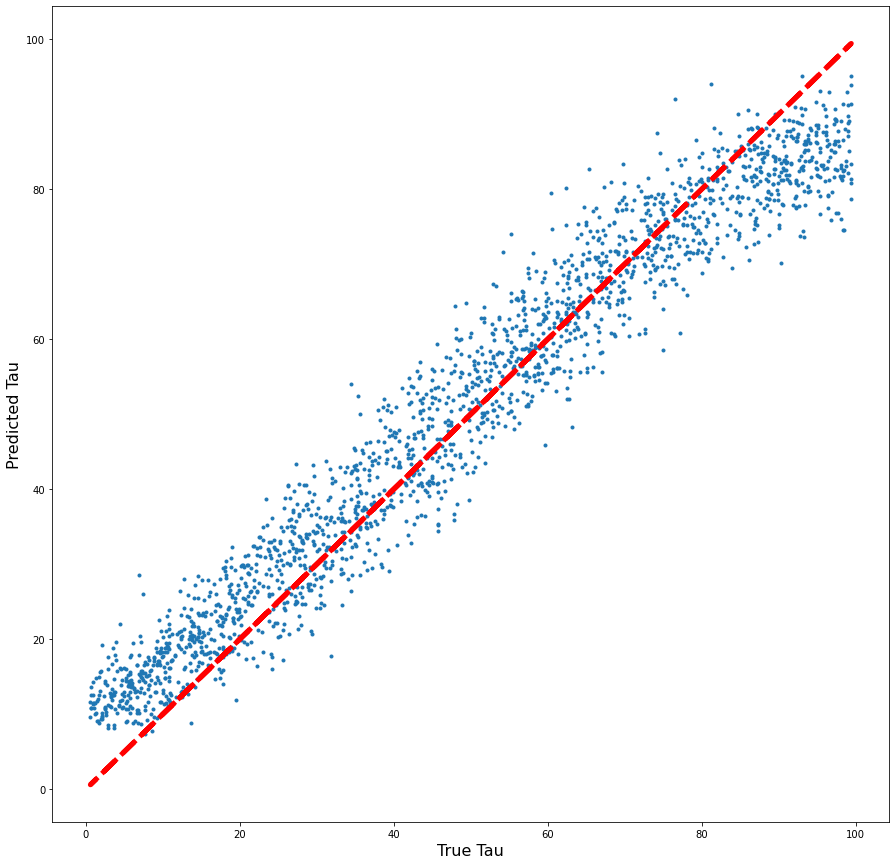

In [27]:
def train_test_model():
    # Making a model.                                                                                                                                                                   
    model = Sequential()

    # Added Layers.                                                                                                                                                                     
    #model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Dense(8, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(8, activation="relu"))
    #model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(1, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
    model.add(BatchNormalization())
    model.add(Flatten())

    #model.add(Dense(1,activation="linear"))                                                                                                                                            
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

    model.compile(optimizer= "adam", loss = neg_log_likelihood, metrics=["mae"])#"mae","mse"])#)#"mse")#"mape")                                                                                                  

    # Visualize Model                                                                                                                                                                                                           
    print(model.summary())
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=20, batch_size=HP_BATCH_SIZE,
          callbacks=[plotlosses],
          verbose=1)
    return model

model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

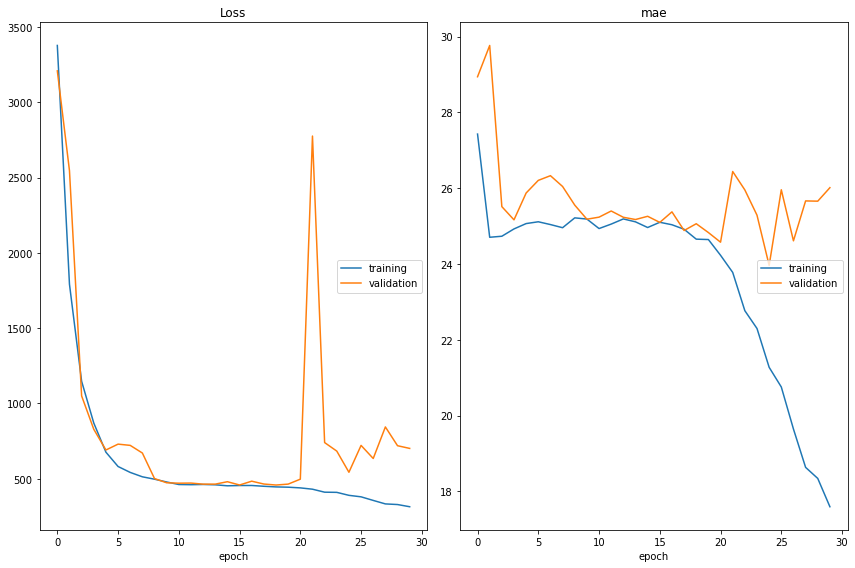

Loss
	training         	 (min:  313.948, max: 3377.906, cur:  313.948)
	validation       	 (min:  458.118, max: 3209.165, cur:  701.436)
mae
	training         	 (min:   17.598, max:   27.428, cur:   17.598)
	validation       	 (min:   23.964, max:   29.765, cur:   26.014)
(2000, 32, 32, 1)
(2000,)
(2000,)


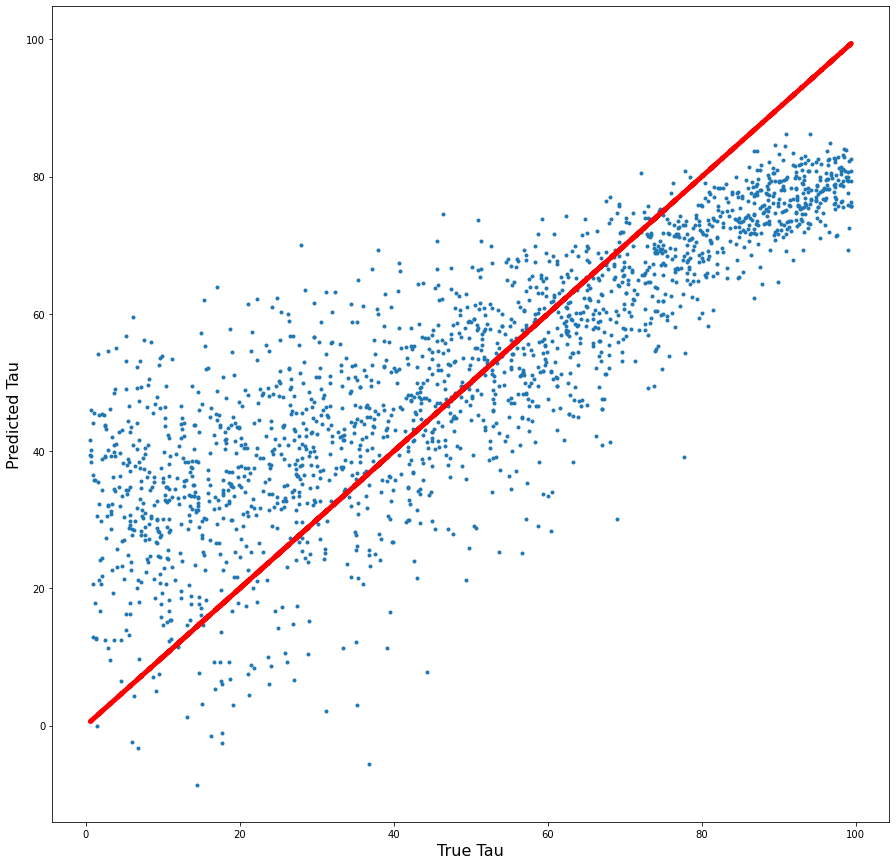

In [26]:
def train_test_model():
    # Making a model.                                                                                                                                                                   
    model = Sequential()

    # Added Layers.                                                                                                                                                                     
    #model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Dense(8, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(8, activation="relu"))
    #model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(1, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
    model.add(BatchNormalization())
    model.add(Flatten())

    #model.add(Dense(1,activation="linear"))                                                                                                                                            
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

    model.compile(optimizer= "adam", loss = neg_log_likelihood, metrics=["mae"])#"mae","mse"])#)#"mse")#"mape")                                                                                                  

    # Visualize Model                                                                                                                                                                                                           
    print(model.summary())
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=30, batch_size=HP_BATCH_SIZE,
          callbacks=[plotlosses],
          verbose=1)
    return model

model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

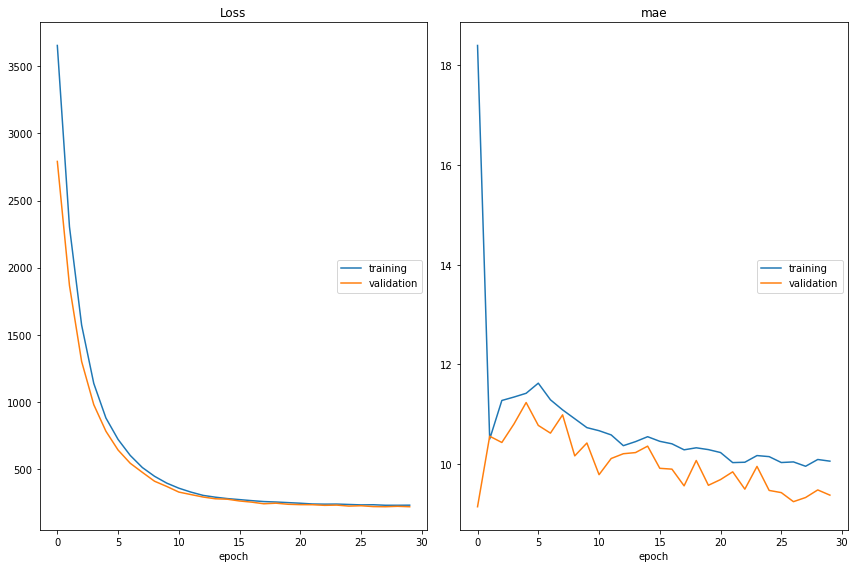

Loss
	training         	 (min:  231.490, max: 3654.171, cur:  232.194)
	validation       	 (min:  220.572, max: 2790.945, cur:  220.572)
mae
	training         	 (min:    9.955, max:   18.402, cur:   10.058)
	validation       	 (min:    9.143, max:   11.235, cur:    9.376)
(2000, 32, 32, 1)
(2000,)
(2000,)


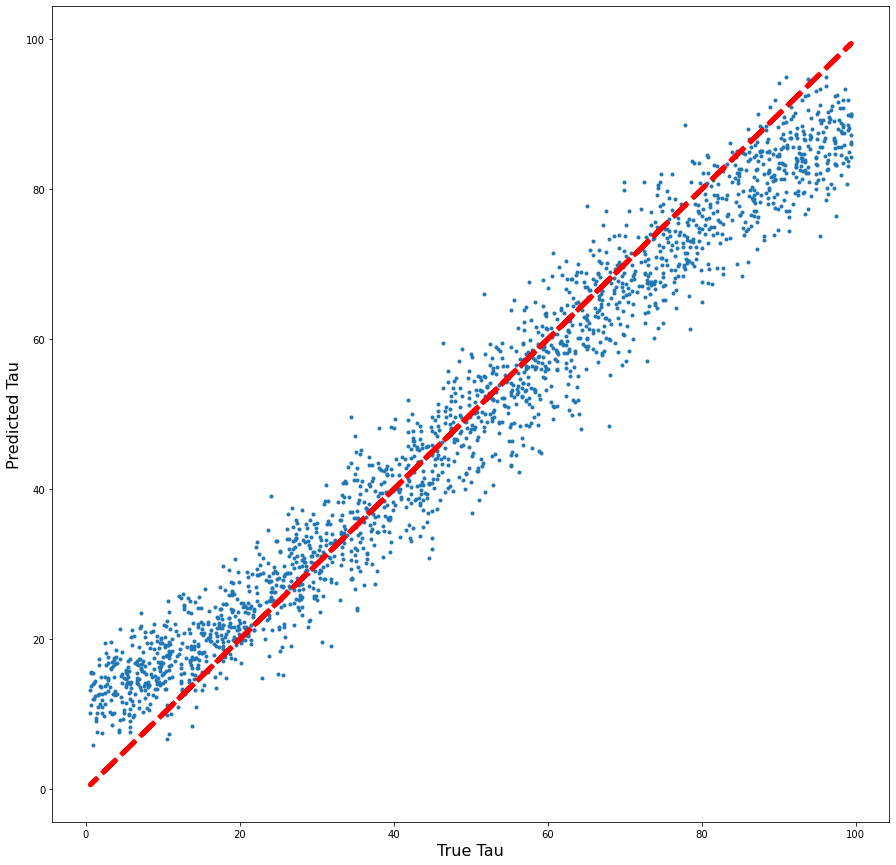

In [29]:
def train_test_model():
    # Making a model.                                                                                                                                                                   
    model = Sequential()

    # Added Layers.                                                                                                                                                                     
    #model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Dense(8, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(8, activation="relu"))
    #model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(1, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
    model.add(BatchNormalization())
    model.add(Flatten())

    #model.add(Dense(1,activation="linear"))                                                                                                                                            
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

    model.compile(optimizer= "adam", loss = neg_log_likelihood, metrics=["mae"])#"mae","mse"])#)#"mse")#"mape")                                                                                                  

    # Visualize Model                                                                                                                                                                                                           
    print(model.summary())
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=30, batch_size=HP_BATCH_SIZE,
          callbacks=[plotlosses],
          verbose=1)
    return model

model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

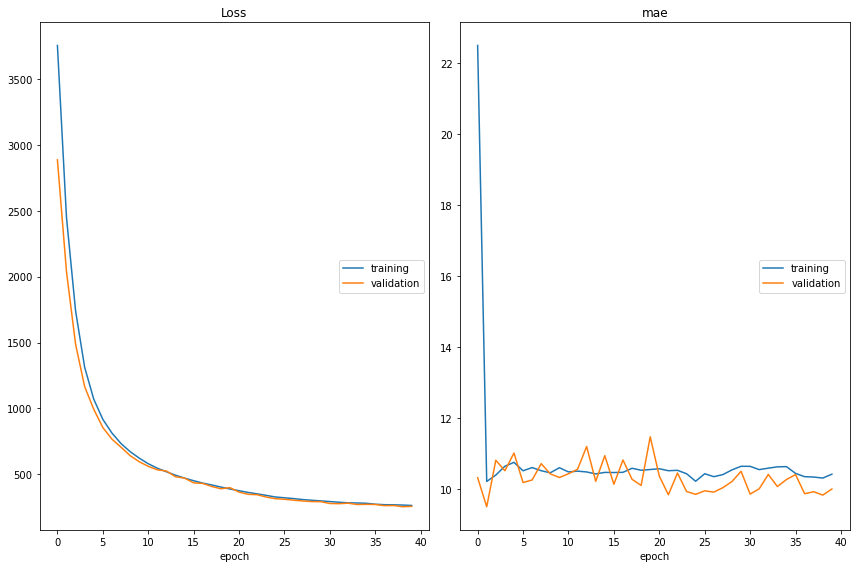

Loss
	training         	 (min:  264.478, max: 3753.284, cur:  264.478)
	validation       	 (min:  254.729, max: 2885.991, cur:  257.579)
mae
	training         	 (min:   10.208, max:   22.508, cur:   10.412)
	validation       	 (min:    9.494, max:   11.467, cur:    9.994)
(2000, 32, 32, 1)
(2000,)
(2000,)


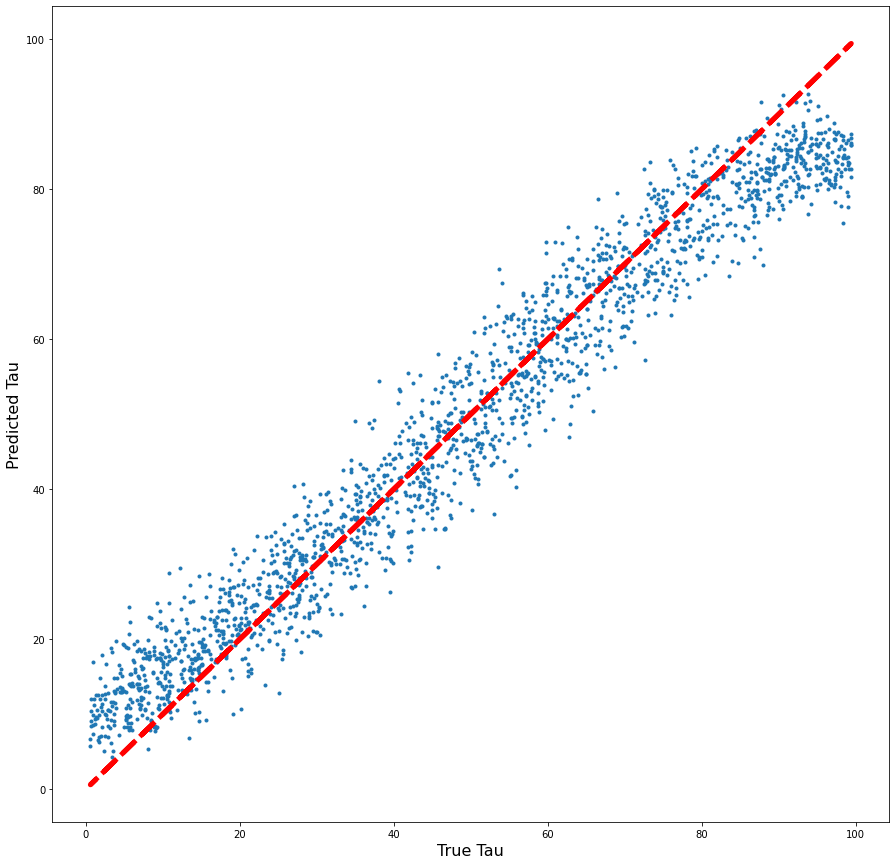

In [28]:
def train_test_model():
    # Making a model.                                                                                                                                                                   
    model = Sequential()

    # Added Layers.                                                                                                                                                                     
    #model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Dense(8, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(8, activation="relu"))
    #model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(1, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
    model.add(BatchNormalization())
    model.add(Flatten())

    #model.add(Dense(1,activation="linear"))                                                                                                                                            
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

    model.compile(optimizer= "adam", loss = neg_log_likelihood, metrics=["mae"])#"mae","mse"])#)#"mse")#"mape")                                                                                                  

    # Visualize Model                                                                                                                                                                                                           
    print(model.summary())
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=40, batch_size=HP_BATCH_SIZE,
          callbacks=[plotlosses],
          verbose=1)
    return model

model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

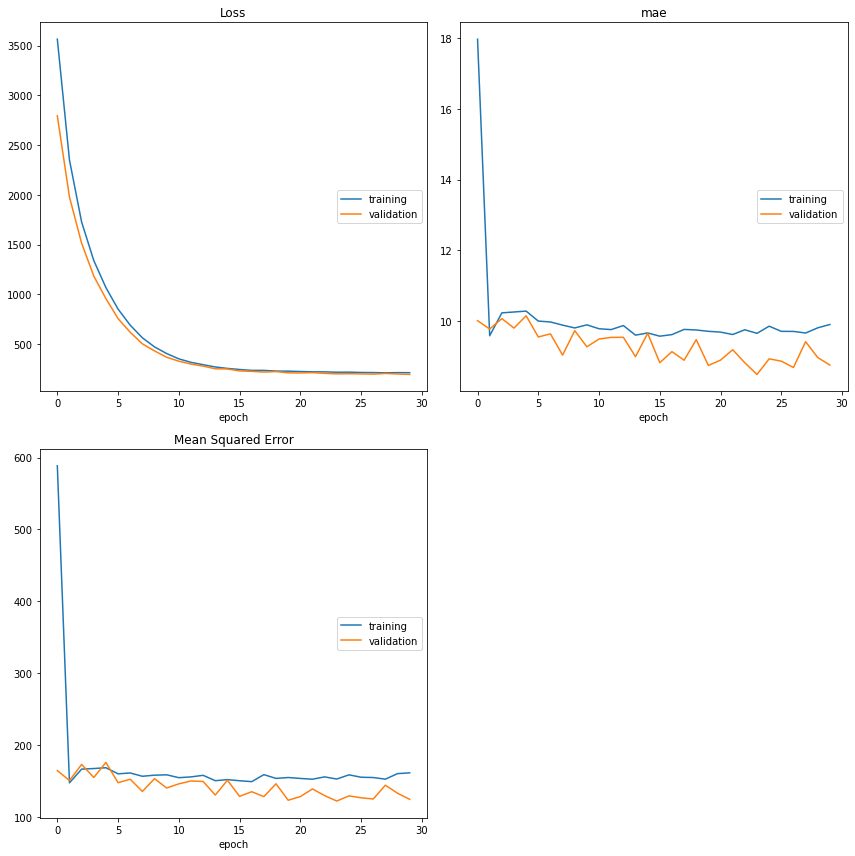

Loss
	training         	 (min:  211.406, max: 3565.369, cur:  212.784)
	validation       	 (min:  195.126, max: 2794.733, cur:  195.126)
mae
	training         	 (min:    9.574, max:   17.969, cur:    9.904)
	validation       	 (min:    8.492, max:   10.150, cur:    8.757)
Mean Squared Error
	training         	 (min:  147.302, max:  588.731, cur:  161.204)
	validation       	 (min:  121.961, max:  175.658, cur:  124.334)
(2000, 32, 32, 1)
(2000,)
(2000,)


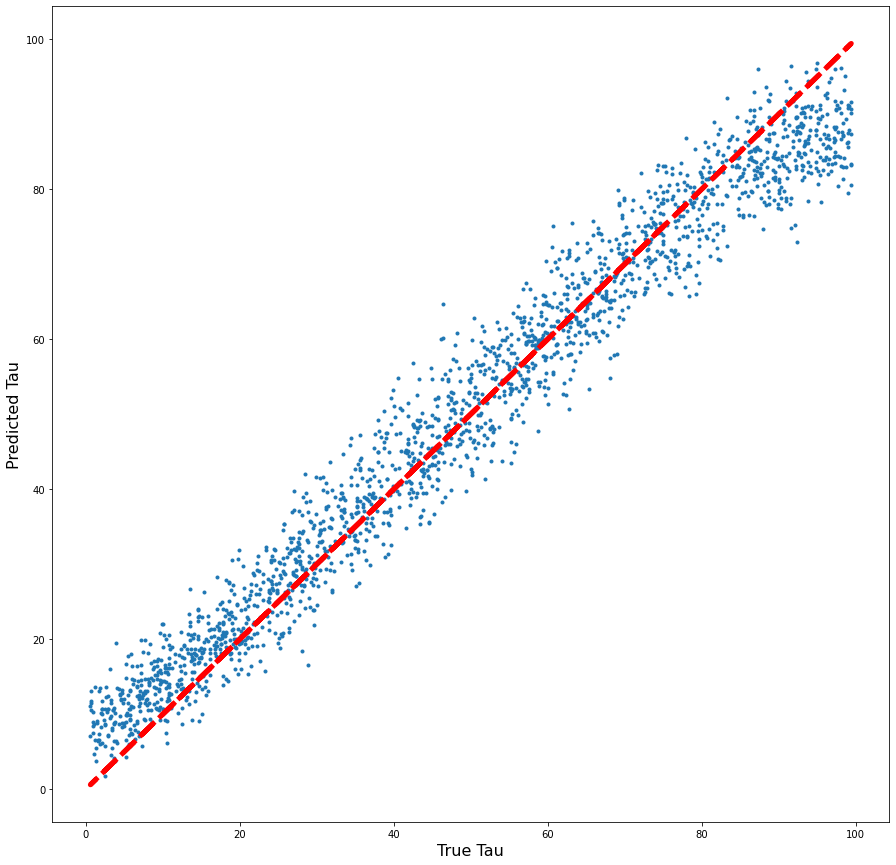

In [19]:
def train_test_model():
    # Making a model.                                                                                                                                                                   
    model = Sequential()

    # Added Layers.                                                                                                                                                                     
    #model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Dense(8, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(8, activation="relu"))
    #model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(1, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
    model.add(BatchNormalization())
    model.add(Flatten())

    #model.add(Dense(1,activation="linear"))                                                                                                                                            
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

    model.compile(optimizer= "adam", loss = neg_log_likelihood, metrics=["mae","mse"])#)#"mse")#"mape")                                                                                                  

    # Visualize Model                                                                                                                                                                                                           
    print(model.summary())
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=30, batch_size=HP_BATCH_SIZE,
          callbacks=[plotlosses],
          verbose=1)
    return model

model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

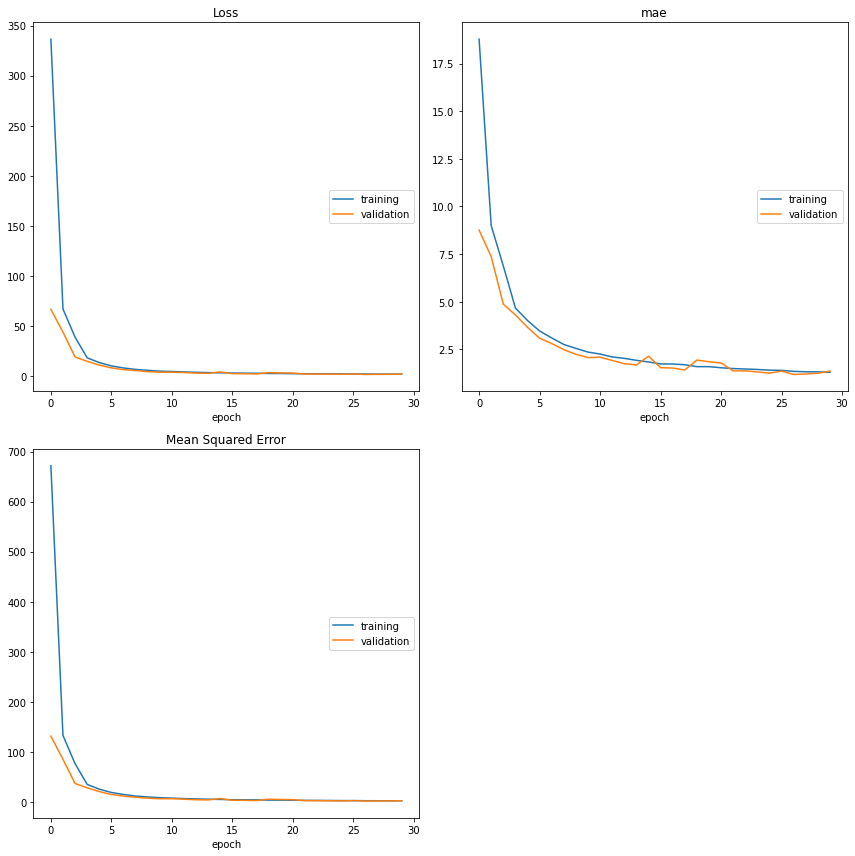

Loss
	training         	 (min:    2.240, max:  336.391, cur:    2.240)
	validation       	 (min:    1.953, max:   66.929, cur:    2.305)
mae
	training         	 (min:    1.299, max:   18.778, cur:    1.299)
	validation       	 (min:    1.185, max:    8.760, cur:    1.361)
Mean Squared Error
	training         	 (min:    2.667, max:  671.536, cur:    2.667)
	validation       	 (min:    2.205, max:  131.792, cur:    2.876)
(2000, 32, 32, 1)
(2000,)
(2000,)


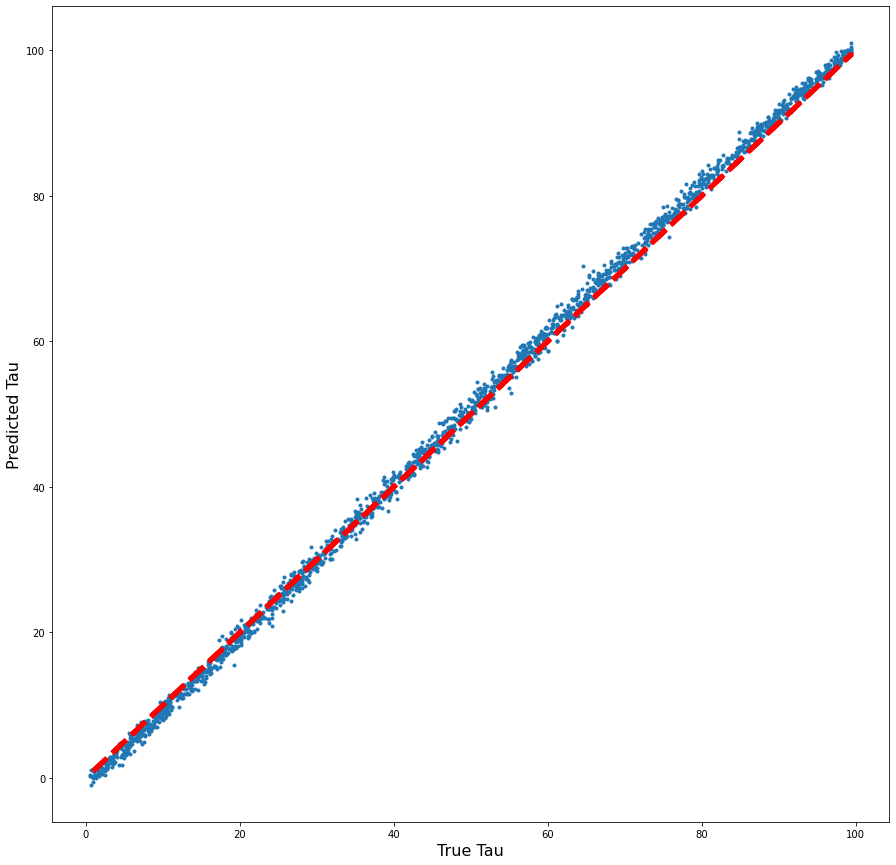

In [38]:
def train_test_model():
    # Making a model.                                                                                                                                                                   
    model = Sequential()

    # Added Layers.                                                                                                                                                                     
    #model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Dense(8, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(8, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(1, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
    model.add(BatchNormalization())
    model.add(Flatten())

    #model.add(Dense(1,activation="linear"))                                                                                                                                            
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

    model.compile(optimizer= "adam", loss = neg_log_likelihood, metrics=["mae","mse"])#)#"mse")#"mape")                                                                                                  

    # Visualize Model                                                                                                                                                                                                           
    print(model.summary())
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=30, batch_size=HP_BATCH_SIZE,
          callbacks=[plotlosses],
          verbose=1)
    return model

model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

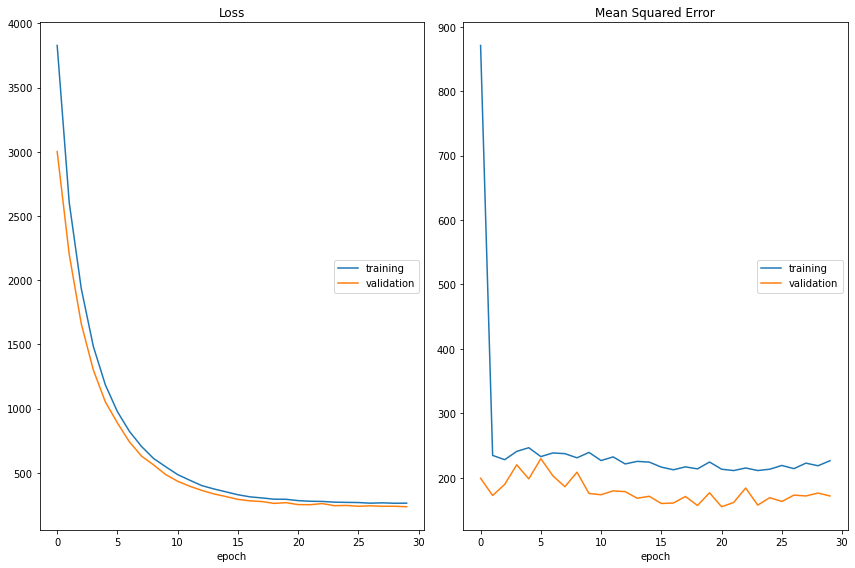

Loss
	training         	 (min:  262.445, max: 3828.398, cur:  263.186)
	validation       	 (min:  235.414, max: 3001.867, cur:  235.414)
Mean Squared Error
	training         	 (min:  211.209, max:  870.932, cur:  226.507)
	validation       	 (min:  155.074, max:  229.662, cur:  171.759)
(2000, 32, 32, 1)
(2000,)
(2000,)


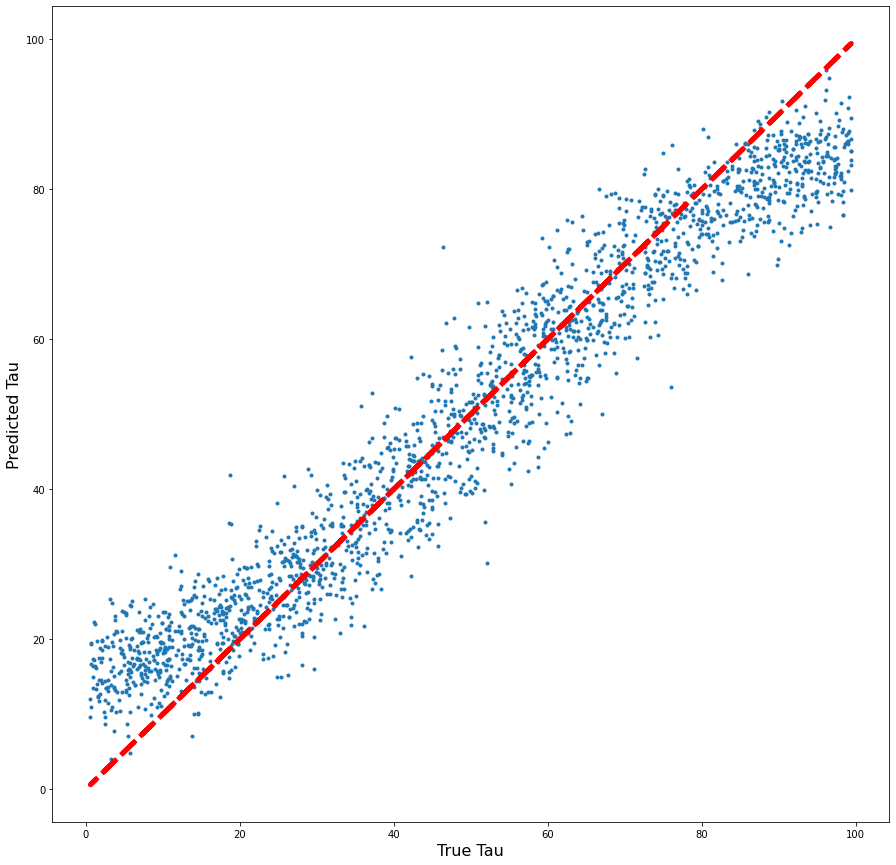

In [14]:
def train_test_model():
    # Making a model.                                                                                                                                                                   
    model = Sequential()

    # Added Layers.                                                                                                                                                                     
    #model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Dense(8, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(8, activation="relu"))
    #model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(1, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
    model.add(BatchNormalization())
    model.add(Flatten())

    #model.add(Dense(1,activation="linear"))                                                                                                                                            
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

    model.compile(optimizer= "adam", loss = elbo, metrics=["mse"])#"mae","mse"])#neg_log_likelihood)#"mse")#"mape")                                                                                                  

    # Visualize Model                                                                                                                                                                                                           
    print(model.summary())
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=30, batch_size=HP_BATCH_SIZE,
          callbacks=[plotlosses],
          verbose=1)
    return model

model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

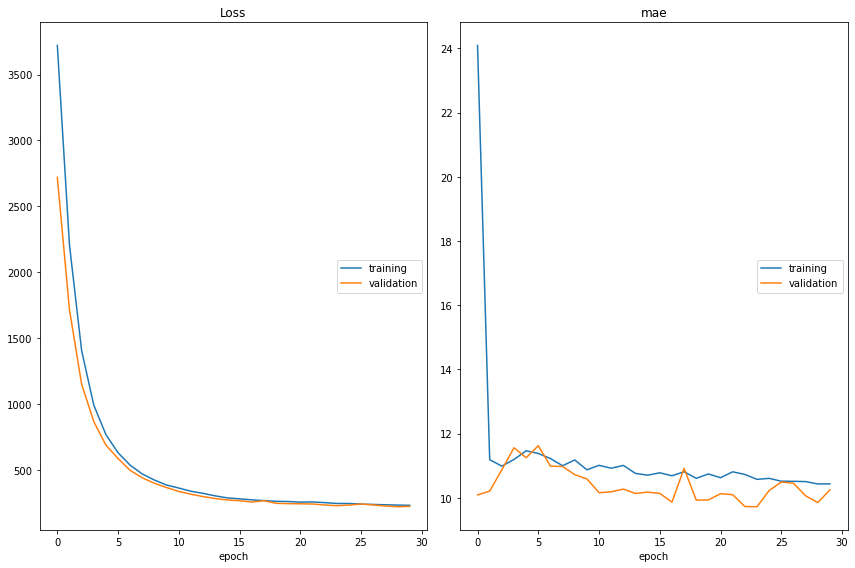

Loss
	training         	 (min:  229.645, max: 3720.665, cur:  229.645)
	validation       	 (min:  218.844, max: 2720.025, cur:  221.565)
mae
	training         	 (min:   10.434, max:   24.092, cur:   10.436)
	validation       	 (min:    9.724, max:   11.626, cur:   10.250)
(2000, 32, 32, 1)
(2000,)
(2000,)


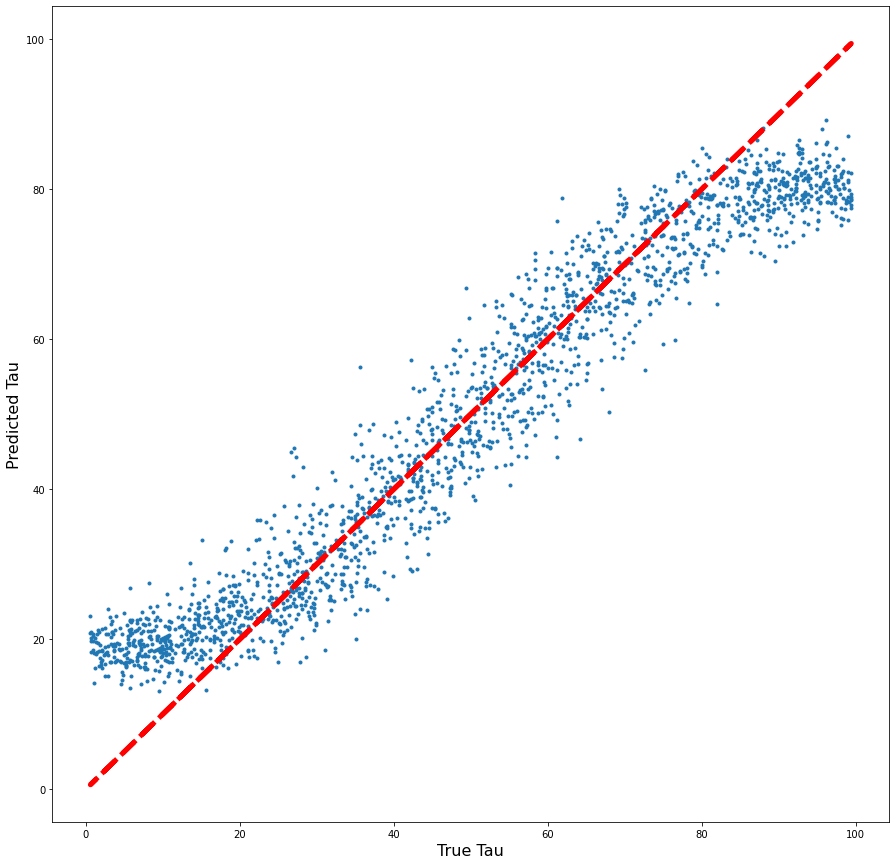

In [13]:
def train_test_model():
    # Making a model.                                                                                                                                                                   
    model = Sequential()

    # Added Layers.                                                                                                                                                                     
    #model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Dense(8, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(8, activation="relu"))
    #model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(1, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
    model.add(BatchNormalization())
    model.add(Flatten())

    #model.add(Dense(1,activation="linear"))                                                                                                                                            
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

    model.compile(optimizer= "adam", loss = elbo, metrics=["mae"])#"mae","mse"])#neg_log_likelihood)#"mse")#"mape")                                                                                                  

    # Visualize Model                                                                                                                                                                                                           
    print(model.summary())
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=30, batch_size=HP_BATCH_SIZE,
          callbacks=[plotlosses],
          verbose=1)
    return model

model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

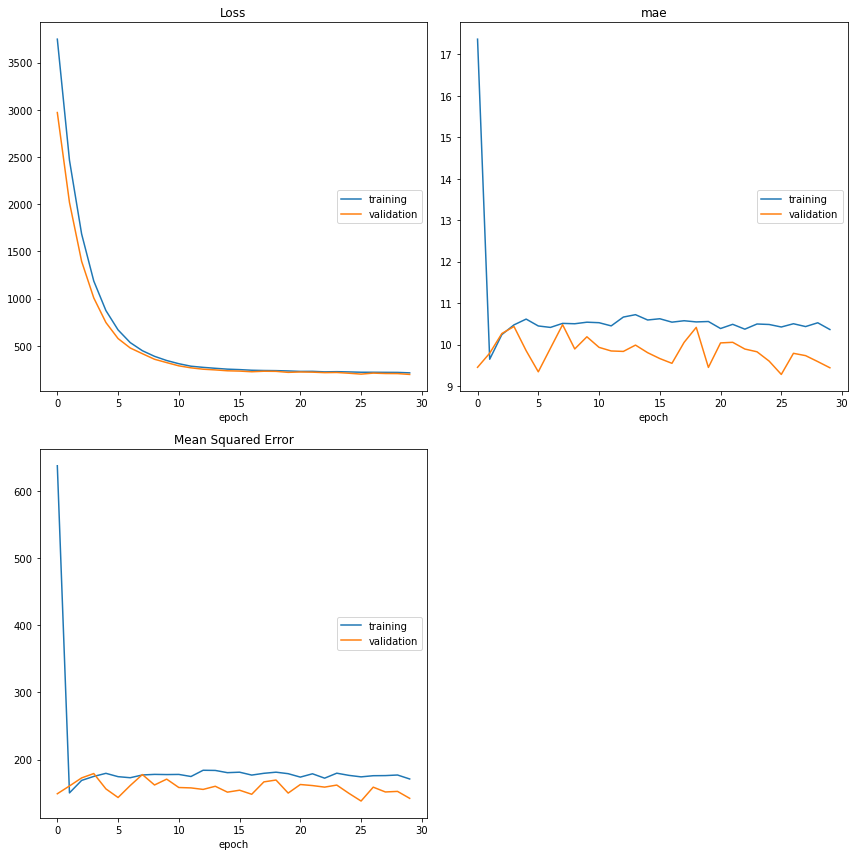

Loss
	training         	 (min:  214.900, max: 3747.571, cur:  214.900)
	validation       	 (min:  198.041, max: 2970.582, cur:  198.041)
mae
	training         	 (min:    9.645, max:   17.366, cur:   10.362)
	validation       	 (min:    9.278, max:   10.478, cur:    9.439)
Mean Squared Error
	training         	 (min:  150.355, max:  637.588, cur:  171.071)
	validation       	 (min:  138.211, max:  179.150, cur:  142.227)
(2000, 32, 32, 1)
(2000,)
(2000,)


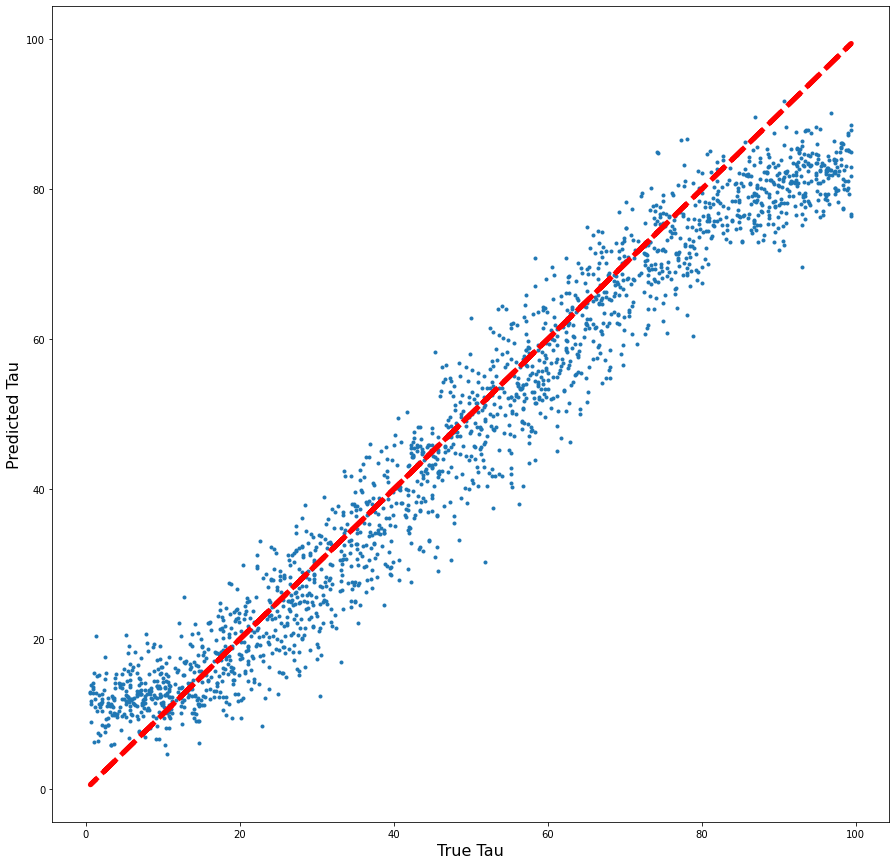

In [15]:
def train_test_model():
    # Making a model.                                                                                                                                                                   
    model = Sequential()

    # Added Layers.                                                                                                                                                                     
    #model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1), padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Dense(8, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(8, activation="relu"))
    #model.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(4, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(4, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(4, activation="relu"))
    #model.add(Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(2, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(2, activation="relu"))
    #model.add(Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(3, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    #model.add(Dense(1, activation = 'relu'))
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))
    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(1, kernel_size=3, activation = 'relu', padding = 'same'))
    #model.add(Conv2D(1, kernel_size = 3, activation = 'relu', padding = 'same'))                                                                                                       
    model.add(BatchNormalization())
    model.add(Flatten())

    #model.add(Dense(1,activation="linear"))                                                                                                                                            
    model.add(tfp.layers.DenseFlipout(1, activation="linear"))
    model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))                                                                                                     

    model.compile(optimizer= "adam", loss = elbo, metrics=["mae","mse"])#neg_log_likelihood)#"mse")#"mape")                                                                                                  

    # Visualize Model                                                                                                                                                                                                           
    print(model.summary())
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=30, batch_size=HP_BATCH_SIZE,
          callbacks=[plotlosses],
          verbose=1)
    return model

model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)